# Compresión de imágenes con el algoritmo k-means

En este ejemplo usaremos k-means para comprimir una imagen en formato PNG.

En una representación color de 24-bit de una imagen, cada pixel como 3 enteros sin signo de 8 bits (con rango de 0 a 255) que especifican la intesidad del Rojo, Verde y Azul. Esta codificación por lo general se lo denomina codificación RGB.

En este ejemplo nuestra imagen tiene miles de colores y vamos a reducirla a 16 colores. De esta manera podemos representar (comprimir) la imagen de una manera eficiente. Es decir, solo necesitamos almacenar los valores RGB de los 16 valores, y por cada pixel en la imagen ahora necesitamos almacenar solo el indice del color en ese pixel (donde solo necesitamos 4 bits para representar 16 posibilidades).

#### Configuración de tamaño de gráficos

In [1]:
options(repr.plot.width=5, repr.plot.height=4, scipen = 999)

#### Instalación y carga de paquetes necesarios

In [2]:
list.of.packages <- c('ggplot2', 'R.matlab', 'png', 'IRdisplay')

new.packages <- list.of.packages[!(list.of.packages %in% installed.packages()[,"Package"])]
if(length(new.packages)) install.packages(new.packages, repos = "https://cran.r-project.org")

library(ggplot2)
library(R.matlab)
library(png)
library(IRdisplay)

also installing the dependencies 'R.methodsS3', 'R.oo', 'R.utils'



package 'R.methodsS3' successfully unpacked and MD5 sums checked
package 'R.oo' successfully unpacked and MD5 sums checked
package 'R.utils' successfully unpacked and MD5 sums checked
package 'R.matlab' successfully unpacked and MD5 sums checked
package 'png' successfully unpacked and MD5 sums checked

The downloaded binary packages are in
	C:\Users\Administrator\AppData\Local\Temp\Rtmpk5xpCs\downloaded_packages


Warning message:
"package 'R.matlab' was built under R version 3.3.3"R.matlab v3.6.1 (2016-10-19) successfully loaded. See ?R.matlab for help.

Attaching package: 'R.matlab'

The following objects are masked from 'package:base':

    getOption, isOpen



#### Cargamos la imagen en un formato array de dimensiones: altura x ancho x canales. Estos canales son los RGB.

In [3]:
A <- readPNG('bird_small.png')

dim(A) #El array que representa a la imagen es de 128 x 128 x 3 

range(A) #los valores de este array están entre 0 y 1 no hace falta escalar

[1] 128 128   3

[1] 0.02352941 1.00000000

#### Visualizamos la imagen con la que vamos a trabajar

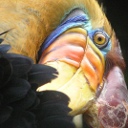

In [4]:
display_png(file='bird_small.png')

#### Extraemos las dimensiones del array

In [6]:
img_size <- dim(A)
img_size

[1] 128 128   3

Transformamos nuestra imagen a una matriz de Nx3 donde N es la cantidad de bits de la imagen (128x128 en este caso)
Cada fila tendrá la intensidad del pixel Rojo, Azul o Verde.
Sobre esta matriz utilizaremos el algoritmo de clustering k-means.

In [7]:
X <- matrix(A, img_size[1] * img_size[2], 3)
str(X)
head(X)

 num [1:16384, 1:3] 0.859 0.902 0.894 0.855 0.827 ...


0.8588235,0.7058824,0.4039216
0.9019608,0.7568627,0.4666667
0.8941176,0.7490196,0.4823529
0.8549020,0.7137255,0.4745098
0.8274510,0.6901961,0.4274510
0.8627451,0.7098039,0.4470588


### Aplicación del algoritmo K-means sobre el dataset

#### Inicializamos algunos valores

In [8]:
K <- 16
max_iters <- 10

Como usaremos 16 centroides utilizaremos 16 puntos como centroides iniciales, para ello tomaremos 16 puntos al azar de nuestro dataset.

In [9]:
set.seed(123)
index <- sample(1:nrow(X), K)
initial_centroids <- as.matrix(X[index,])

cat("Posiciones iniciales de centroides:\n")
initial_centroids

Posiciones iniciales de centroides:


0.10980392,0.10980392,0.10980392
0.63137255,0.49803922,0.41568627
0.63921569,0.41176471,0.35686275
0.05098039,0.05882353,0.05490196
0.13725490,0.13725490,0.10980392
0.07058824,0.07450980,0.06666667
0.99607843,0.95686275,0.72941176
0.08627451,0.10588235,0.05882353
0.95686275,0.92549020,0.56862745
0.99607843,0.82352941,0.72549020
0.16470588,0.15294118,0.10588235


### Ejecutamos el algoritmo kmeans

#### Función para encontrar los centroides más cercanos

In [10]:
findClosestCentroids <- function(X, centroids) {
    
    K <- nrow(centroids)
    m <- nrow(X)
    
    idx <- rep(0, m)
    
    for(i in 1:m) {
        
        d_min <- 99999999
        
        for(j in 1:K) {
            
            distance <- (sum((X[i,] - centroids[j,]) ^ 2)) ^ (1/2)
            
            if(distance < d_min) {
                d_min <- distance
                idx[i] <- j
            }
        }
    }
    
    return(idx)
    
}

#### Función para calcular las nuevas posiciones de cada centroide

In [11]:
computeCentroids <- function(X, idx, K) {
    
    m <- nrow(X)
    n <- ncol(X)
    idx <- as.numeric(idx)
    
    centroids <- matrix(rep(0, K * n), ncol = n, nrow = K)
    
    for(i in 1:K) {
        
        idx_X <- which(idx %in% i)
        
        centroids[i,] <- colMeans(X[idx_X,])
    }
    
    return(centroids)
}

#### Función que encapsula el algoritmo kmeans

In [12]:
runkMeans <- function(X, initial_centroids, max_iters) {
    
    m <- nrow(X)
    n <- ncol(X)
    
    K <- nrow(initial_centroids)
    centroids <- initial_centroids
    idx <- rep(0, m)
    
    for(i in 1:max_iters) {
        
        idx <- findClosestCentroids(X, centroids)
        centroids <- computeCentroids(X, idx, K)
        
    }
    
    return(list(centroids = centroids, idx = idx))
    
}

results <- runkMeans(X, initial_centroids, max_iters)
centroids <- results[[1]]
idx <- results[[2]]

Ahora tenemos el cluster más cercano a cada observación (o pixel)

In [13]:
cbind(tail(X), tail(idx))

"[16379,]",0.3921569,0.2470588,0.2431373,11
"[16380,]",0.3411765,0.2039216,0.1960784,5
"[16381,]",0.3058824,0.1686275,0.1568627,5
"[16382,]",0.2823529,0.2000000,0.1686275,5
"[16383,]",0.2313725,0.1686275,0.1647059,5
"[16384,]",0.2039216,0.1529412,0.1333333,12


Ahora podemos recuperar la imagen desde los indices (idx, contiene el cluster al que corresponde cada pixel) mapeando cada pixel al valor del centroide de dicho pixel.

In [14]:
X_recovered <- centroids[idx,]
str(X_recovered)

 num [1:16384, 1:3] 0.889 0.889 0.889 0.889 0.889 ...


Volvemos a transformar nuestro array a las dimensiones apropiadas.

In [15]:
X_recovered <- array(X_recovered, img_size)
str(X_recovered)

 num [1:128, 1:128, 1:3] 0.889 0.889 0.889 0.889 0.889 ...


Guardamos la imagen comprimida

In [16]:
writePNG(X_recovered, target = "compressed_bird.png")

Imagen original:

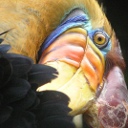

In [18]:
cat("Imagen original:")
display_png(file='bird_small.png')

Imagen comprimida con 16 colores:


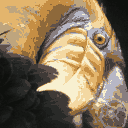

In [19]:
cat("Imagen comprimida con", K, "colores:\n")
display_png(file='compressed_bird.png')

Notemos que hemos reducido considerablemente la cantidad de bits necesarios para representar la imagen. La imagen original requería 24-bits para cada uno de los 128x128 pixeles, resultando en un total de: *128 x 128 x 24 = 393.216 bits*.
La nueva representación requiere algo de costo de almacenamiento en cuanto al diccionario de 16 colores, donde cada uno  requiere 24 bits, pero la imagen en sí solo necesita 4 bits por pixel. Por lo tanto el número final de bits es de: *16 x 24 + 128 x 128 x 4 = 65.920 bits*. Esto es 6 veces menos que la imagen original.

### Ejemplo con 3 clusters:

Imagen comprimida con 3 colores:


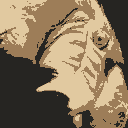

In [20]:
K <- 3
max_iters <- 10

set.seed(123)
index <- sample(1:nrow(X), K)
initial_centroids <- as.matrix(X[index,])

results <- runkMeans(X, initial_centroids, max_iters)
centroids <- results[[1]]
idx <- results[[2]]

X_recovered <- centroids[idx,]
X_recovered <- array(X_recovered, img_size)

writePNG(X_recovered, target = "very_compressed_bird.png")

cat("Imagen comprimida con", K, "colores:\n")
display_png(file='very_compressed_bird.png')

In [21]:
cat('La cantidad de bits requeridos para representar esta imagen será:', K * 24 + 128 * 128 * 2, 'bits.') 

La cantidad de bits requeridos para representar esta imagen será: 32840 bits.